# 5.3 Using a pretrained convnet
A common and effective approach to deep learning on small image datasets is to use a pretrained network, which is a saved network that was previously trained on a large dataset. If the pretrained model was trained on a large enough dataset, then its features can prove useful for many different computer vision problems, even if they are unlike the new task you are training it to perform. Portability of learned features across different problems is a key advantage to deep learning compared to older, shallow-learning approaches.

For this lesson, we will use a large convnet trained on the **ImageNet** dataset which consists of 1.4 million labeled images of animals spanning 1,000 different classes. We will also use VGG16 architecture which is a simple and widely used convnet architecture for ImageNet.

There are two ways to use a pretrained network: **feature extraction** and **fine-tuning**. We will cover both in following sections.

### 5.3.1 Feature extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier that is trained from scratch.

To review, convnets used to image classification comprise two parts: they begin with a series of pooling and convolution layers, and end with a densely connected classifier. The first portion is called the *convolutional base*. Feature extraction consists of taking the convolutional base of a previously trained network, running new data through it, and trainined a new classifier on top of the output.

![feature extraction](images/5_3_1_featextr.jpg)

One should refrain from reusing the densely connected classifier portion of the pretrained model because the representations learned by the convolutional base are likely to be more generic and reusable. The representations learned from the densely connected classifier will be specific to the set of classes on which the model was trained, and generally not broad or flexible enough to be reused to train a new model. In addition, densely connected layers no longer contain any information about *where* objects are located in an input image, which can also be burdensome.

The level of generality of the representation extracted by convolutional layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps such as visual edges, colors, and textures. Layers that are higher up extract more abstract concepts such as "cat ear" or "dog eye".

Because the ImageNet class set contains multiple dog and cat classes, it's likely to be beneficial to reuse the information contained in the densely connected layers of the original model, but we'll choose not to for the sake of learning the more common practice of only using the convolutional base (specifically the VGG16 architecture in this case).

Let's instantiate the VGG16 model, which comes prepackaged with Keras.

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

Using TensorFlow backend.


58826752/58889256 [============================>.] - ETA: 0s

Let's break down the three arguments we passed to VGG16:
 - **`weights`** specifies the weight checkpoint from which to initialize the model.
 - **`include_top`** refers to including the densely connected classifier on top of the network.
 - **`input_shape`** is the shape of the image tensors that we will feed the network, but this is an optional argument. 
 
Let's view the detail of the VGG16 convolutional base architecture:

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape (4, 4, 512) which is where we will stick a densely connected classifier.

There are two ways to proceed from this point:
 1. Running the convolutional base over the dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, however, this method prevents you from using data augmentation.
 2. Extending the model you have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end to end on the input data. This will allow data augmentation, but this technique is far more expensive than the first method.
 
**FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION**

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [4]:
base_dir = '/Volumes/RobStorage/Desktop/Python_Practice/DL_with_Python/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [6]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150),
                                            batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Because the extracted features are currently of shape (`samples, 4, 4, 512`), we'll feed them through a densely connected classifier. To do this, we must first flatten them to (`samples, 8192`):

In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels we just recorded.

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s - loss: 0.6047 - acc: 0.6635 - val_loss: 0.4498 - val_acc: 0.8030
Epoch 2/30
2000/2000 [==============================] - 4s - loss: 0.4222 - acc: 0.8010 - val_loss: 0.3665 - val_acc: 0.8430
Epoch 3/30
2000/2000 [==============================] - 5s - loss: 0.3607 - acc: 0.8475 - val_loss: 0.3242 - val_acc: 0.8630
Epoch 4/30
2000/2000 [==============================] - 5s - loss: 0.3201 - acc: 0.8695 - val_loss: 0.2989 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 5s - loss: 0.2907 - acc: 0.8840 - val_loss: 0.2834 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 5s - loss: 0.2638 - acc: 0.8970 - val_loss: 0.2736 - val_acc: 0.8890
Epoch 7/30
2000/2000 [==============================] - 5s - loss: 0.2481 - acc: 0.9060 - val_loss: 0.2667 - val_acc: 0.8910
Epoch 8/30
2000/2000 [==============================] - 4s - loss: 0.2277 - a

Because we only had to deal with two `Dense` layers, the training should be extremely fast.

Let's take a look at the loss and accuracy curves during training:

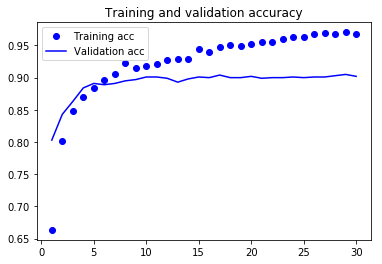

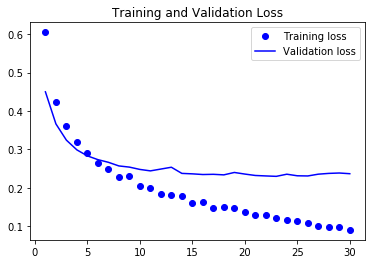

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 90% before it begins to plateau, which is significantly better than the model we trained from scratch which attained an accuracy of 82%. Unfortunately, the plots also indicate that we are overfitting almost from the start, despite using dropout. The reason for that is because this technique doesn't use data augmentation, which is critical for preventing overfitting with small image datasets.

**FEATURE EXTRACTION WITH DATA AUGMENTATION**
Now, we will review the second technique for doing feature extraction, which is much slower and more expensive, but allows us to use data augmentation during training.

 - **Note**: training this model on a CPU is nearly impossible. Only attempt to replicate code if you have access to a GPU.
 
Because models behave just like layers, we can add a model (like `conv_base`) to a `Sequential` model just like we would add a layer:

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


The convolutional base of VGG16 has 14,714,688 parameters, which is pretty big. The classifier we're adding on top has 2 million parameters.

Before compiling and training the model, it's important to freeze the convolutional base. **Freezing** a layer or set of layers means preventing their weights from being updated during training. If we don't do this, representations that were previously learned will be modified during training, which would effectively destroy the network.

In Keras, we freeze a network by setting its `trainable` attribute to `False`:

In [13]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

('This is the number of trainable weights before freezing the conv base:', 30)
('This is the number of trainable weights after freezing the conv base:', 4)


Now, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). In order for these changes to take effect, we must first compile the model. If we ever modify weight trainability after compilation, then we should recompile the model, or these changes will be ignored.

Now to start training the model, with the same data-augmentation configuration from an earlier example:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Validation data shouldn't be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)                

train_generator = train_datagen.flow_from_directory(
        train_dir,  # target directory                                          
        target_size=(150, 150), # resizes images to 150 x 150                               
        batch_size=20,
        class_mode='binary') # because we use binary_crossentropy loss, we need binary labels                                

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Now to plot the results!

![pretrained1](images/5_3_1_pretrain1.jpg)
![pretrained2](images/5_3_1_pretrain2.jpg)

Wow. We were able to reach a validation accuracy of about 96%. This is a major improvement.

### 5.3.2 Fine-tuning
Another widely used technique for model reuse, complementary to feature extraction, is **fine-tuning**. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top layers. It's called *fine-tuning* because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![finetuning](images/5_3_2_finetuning.jpg)

As previously stated, it's necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. It's only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn't already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed.

Steps for fine-tuning:
 1. **Add the custom network on top of an already-trained base network.**
 2. **Freeze the base network.**
 3. **Train the part that was added.**
 4. **Unfreeze some layers in the base network.**
 5. **Jointly train these layers and the part that was added.**
 
We already completed the first three steps, so let's proceed to step 4 and unfreeze `conv_base` and then freeze individual layers inside of it.

Let's take a look at convolutional base again to get a better idea of what we are working on.

In [14]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We will fine-tune the last three convolutional layers, so all layers up to **`block4_pool`** should be frozen, and the layers **`block5_conv1, block5_conv2,`** and **`block_conv3`** should be trainable.

***Why not fine-tune more layers? Why not fine-tune the entire convolutional base?***

We won't fine-tune more layers for two reasons:
 1. Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized features, which are the ones that we need to repurpose for our new problem.
 2. The more parameters we train, the greater the risk of overfitting.

In [15]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can begin fine-tuning the network.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Let's take a look at the results!

![ft1](images/5_3_2_ft1.jpg)
![ft2](images/5_3_2_ft2.jpg)

These curves look pretty noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here is the function to do that:

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

![ft3](images/5_3_2_ft3.jpg)
![ft4](images/5_3_2_ft4.jpg)

The validation accuracy curve looks much cleaner this time! Our accuracy jumped from (an already strong) 96% to **above 97%**!

On the other hand, the loss curve doesn't show any real improvement. So, how could accuracy stay stable or improve if the loss isn't decreasing? This is because what we display is an average of pointwise loss values; but what matters for accuracy is the dirstribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate the model on the test data:

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

The model was able to produce a **test accuracy of 97%!** In the original Kaggle competition around this dataset, this would have been one of the top results. By using modern deep-learning techniques, we managed to reach this result only using a small fraction of the training data available (~10%). Imagine if we were to train on all 20,000 samples!

### 5.3.3 Wrapping up
Here are some key takeaways from the past two sections:

 - Convnets are the best type of machine-learning models for computer-vision tasks. It’s possible to train one from scratch even on a very small dataset, with decent results.
 - On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when you’re working with image data.
 - It’s easy to reuse an existing convnet on a new dataset via feature extraction. This is a valuable technique for working with small image datasets.
 - As a complement to feature extraction, you can use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.
Now you have a solid set of tools for dealing with image-classification problems—in particular with small datasets.